In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import sklearn

In [2]:
# Get data 
data_split_1 = pd.read_parquet( "train1.parquet")
data_split_2 = pd.read_parquet("test.parquet")

data = pd.read_parquet( "train2.parquet")
test = pd.read_parquet( "final_test.parquet")


In [3]:
#get first day and last day for each dataset 
print(f"Data ranges from {data['date'].min()} to {data['date'].max()}")
print(f"test ranges from {test['date'].min()} to {test['date'].max()}")

Data ranges from 2020-09-01 01:00:00 to 2021-09-09 23:00:00
test ranges from 2021-09-10 01:00:00 to 2021-10-18 21:00:00


## Add "external data", ie the weather data

In [166]:
external_data = pd.read_csv( "external_data.csv")

In [167]:
# External data, ie weather data

#rename mulitple columns
external_data = external_data.rename(columns={
    "ff": "wind_speed",
    "ssfrai": "snowfall",
    "t": "temperature",
    "n": "cloud_coverage",
    "rr1":"rainfall_last_1_hour",
    "rr3":"rainfall_last_3_hour",
    "rr6":"rainfall_last_6_hour",
    "rr12":"rainfall_last_12_hour",
    "rr24":"rainfall_last_24_hour"
})

# List of columns to keep
columns_to_keep = ['date', 'temperature', 'cloud_coverage', 'snowfall', 'wind_speed', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24']

# Get a list of all columns that are not in columns_to_keep
columns_to_drop = [col for col in external_data.columns if col not in columns_to_keep]

# Drop these columns
external_data = external_data.drop(columns=columns_to_drop)

# Convert the 'date' column to datetime format
external_data['date'] = pd.to_datetime(external_data['date'])

# Group by 'date' and aggregate the other columns
external_data = external_data.groupby('date').mean()

# Resample to hourly frequency and interpolate missing values
external_data = external_data.resample('H').interpolate()

In [168]:
# Reset the index of 'external_data' so 'date' becomes a column
external_data.reset_index(inplace=True)

# Rename the 'date' column in 'external_data' to match the 'date' column in 'data'
external_data.rename(columns={'index': 'date'}, inplace=True)

# Merge 'data' and 'external_data' on 'date'
data = pd.merge(data, external_data, how='left', on='date')

## Clean dataframe

In [169]:
#check there are no missing values in data
missing_data_rows = data[data.isnull().any(axis=1)]
print(missing_data_rows)


Empty DataFrame
Columns: [counter_id, counter_name, site_id, site_name, bike_count, date, counter_installation_date, counter_technical_id, latitude, longitude, log_bike_count, wind_speed, temperature, cloud_coverage, snowfall]
Index: []


In [170]:
# Assuming 'data' is your DataFrame and 'date' is the column with datetime
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["weekday"] = data["date"].dt.weekday
data["hour"] = data["date"].dt.hour

# Drop the original 'date' column
data = data.drop(columns=["date"])

##### 2 options for hour encoding

In [171]:
# One-hot encode the 'hour' column
data = pd.get_dummies(data, columns=['hour'])

# cyclical encoding of hour
data['hour_sin'] = np.sin(2*np.pi*data['hour']/24)  
data['hour_cos'] = np.cos(2*np.pi*data['hour']/24)
#delete original hour column
data = data.drop(columns=["hour"])

For a feature like 'hour', cyclical encoding can be more effective than one-hot encoding. Here's why:

1. **Preservation of relationships**: Cyclical encoding preserves the cyclical relationship between different hours. For example, 23 (11 PM) and 0 (midnight) are only 1 hour apart, and this relationship is preserved in cyclical encoding. In one-hot encoding, each hour is treated as a separate category, and this relationship is lost.

2. **Dimensionality**: One-hot encoding creates a new binary feature for each unique value in the column. For the 'hour' column, this would result in 24 new features. This can increase the dimensionality of the data significantly, which can lead to longer training times and a risk of overfitting. Cyclical encoding, on the other hand, only adds two new features (for sine and cosine values), regardless of the number of unique hours.

3. **Continuous values**: Cyclical encoding results in continuous values, which can be used in a wider range of models compared to the binary values resulting from one-hot encoding.

However, the best encoding method can depend on the specific dataset and model. It can be beneficial to try different encoding methods and see which one works best for your specific use case.

In [172]:
# remove unnecessary columns from data
data = data.data = data.drop(columns=["bike_count", "site_name", "counter_name", "latitude", 
                                      "longitude", "counter_id", "counter_technical_id"])


C:\Users\Gaspard\AppData\Local\Temp\ipykernel_22184\3048113495.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data = data.data = data.drop(columns=["bike_count", "site_name", "counter_name", "latitude",


In [173]:
# Create a new column 'days_since_installation' as maybe newer stations have a higher demand or are less likely to be broken
data['days_since_installation'] = (pd.Timestamp.now() - data['counter_installation_date']).dt.days

data = data.drop(columns=["counter_installation_date"])

In [13]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

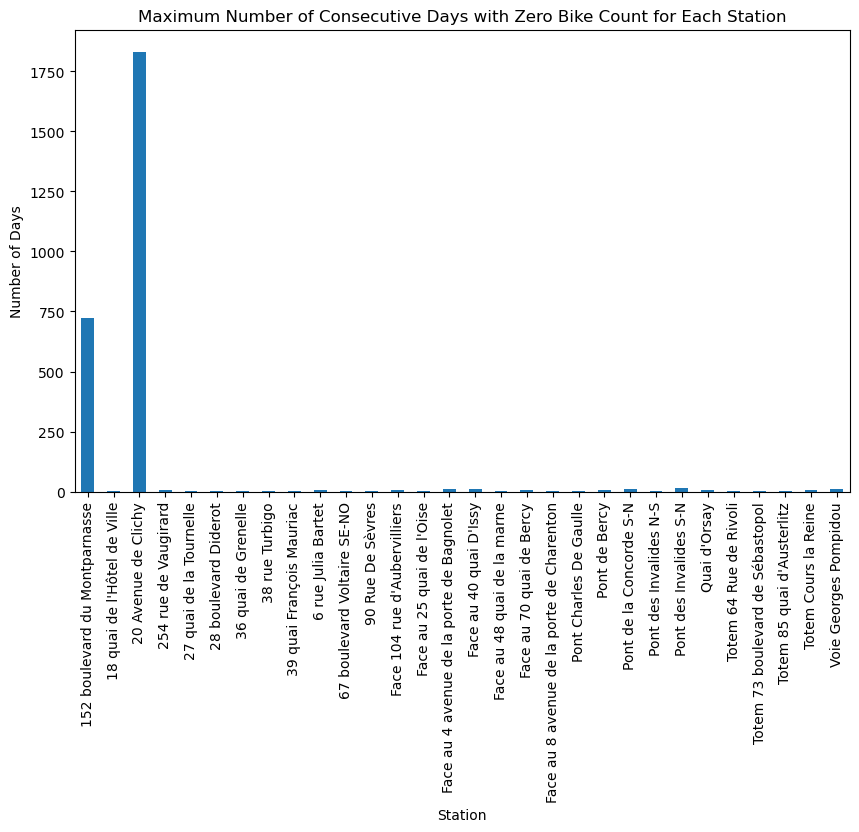

In [19]:
# Group by station and date, calculate the mean of bike_count
grouped_data = data.groupby(['site_name', 'date'])['bike_count'].mean().reset_index()

# Add a column for days with zero bike count
grouped_data['zero_bike_count'] = (grouped_data['bike_count'] == 0)

# Group by station and count consecutive days with zero bike count
grouped_data['consecutive'] = grouped_data.groupby(['site_name', (grouped_data['zero_bike_count'].shift() != grouped_data['zero_bike_count']).cumsum()]).cumcount()+1

# Find the maximum number of consecutive days with zero bike count for each station
max_zero_bike_count = grouped_data[grouped_data['zero_bike_count']].groupby('site_name')['consecutive'].max()

# Plot the results
max_zero_bike_count.plot(kind='bar', figsize=(10, 6))
plt.title('Maximum Number of Consecutive Days with Zero Bike Count for Each Station')
plt.xlabel('Station')
plt.ylabel('Number of Days')
plt.show()

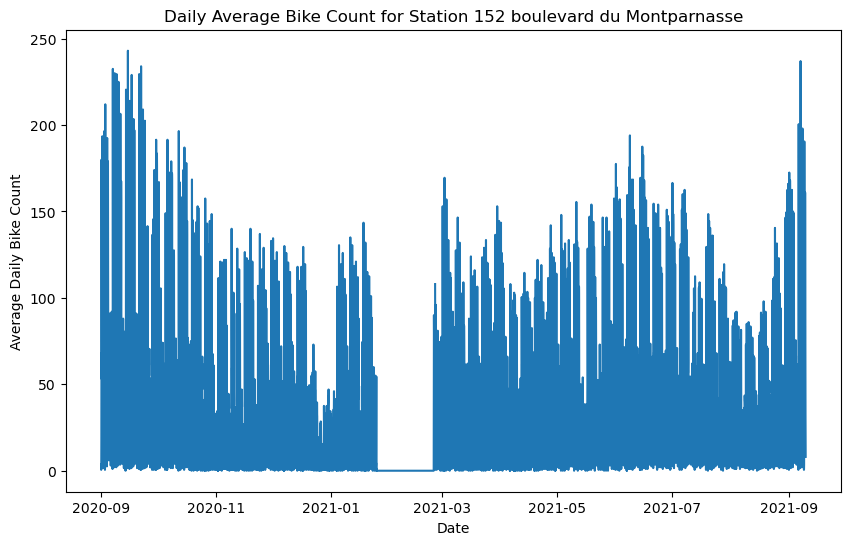

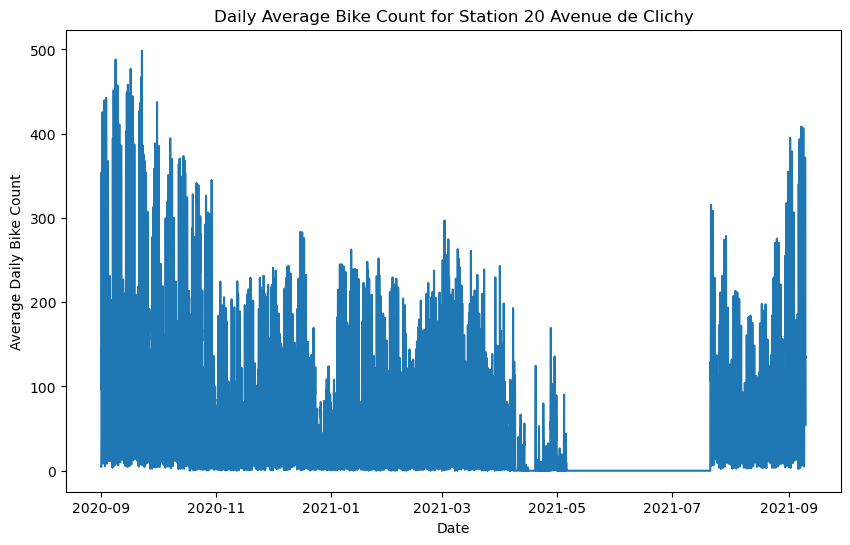

In [21]:
# Check what is goinf on with these 2 stations
stations = ["152 boulevard du Montparnasse", "20 Avenue de Clichy"]

for station in stations:
    station_data = grouped_data[grouped_data['site_name'] == station]
    plt.figure(figsize=(10, 6))
    plt.plot(station_data['date'], station_data['bike_count'])
    plt.title(f'Daily Average Bike Count for Station {station}')
    plt.xlabel('Date')
    plt.ylabel('Average Daily Bike Count')
    plt.show()

# Add another weather feature

As the weather data we were given only worsened the results and as we were convinced that there must be a link between the weather and bike usage we set ourselves the task to find weather data from another source. From the website [infoclimat](https://www.infoclimat.fr/opendata/), got the weather data for the weather tower "Tour Zamansky, Paris 5eme". The website only allows you to download data 7 days at a time, so we were faced with a challenge, we noticed that if we used an api to download the data, the start and end date were in the url. Therefore we could automate the process of downolading the 412 days necessary to cover training and test data  into 59 api calls and then concatenating the data together. We removed unnecessary columns and only kept temperature and rain data, the data was in 10 min intervals but we needed 1 hour intervals so just calculated the average fo the hour.

In [4]:
from datetime import datetime

# Define the start and end dates
start_date = datetime(2020, 9, 1)
end_date = datetime(2021, 10, 18)

# Calculate the number of days between the two dates
num_days = (end_date - start_date).days

print(num_days/7)

58.857142857142854


In [73]:
# get ip address

def get_public_ip():
    response = requests.get('https://api.ipify.org')
    return response.text

print(get_public_ip())

129.104.244.30


In [63]:
import requests

# figure out how to do one api call

api_key = 'S7lSocvAGE8qTypev0o0DK589tZZEXy9tbK96N2QXzBrIjjcPTqg'

# Specify the URL of the API endpoint
url = 'https://www.infoclimat.fr/opendata/?method=get&format=csv&stations[]=ME099&stations[]=000BV&start=2023-12-07&end=2023-12-09&token=S7lSocvAGE8qTypev0o0DK589tZZEXy9tbK96N2QXzBrIjjcPTqg'

# Send the API request and get the response
response = requests.get(url)

# Define the column names
column_names = ['station_id', 'dh_utc', 'temperature', 'pression', 'humidite', 'point_de_rosee', 'vent_moyen', 'vent_rafales', 'vent_direction', 'pluie_3h', 'pluie_1h']

# Read the CSV file
df = pd.read_csv('weather_data.csv', sep=';', names=column_names, skiprows=6, na_values=';')


In [117]:
import requests
from datetime import datetime, timedelta
from io import StringIO

# Automate process of api call to get a whole year if data

# Define the start and end dates
start_date = datetime(2020, 9, 1)
end_date = datetime(2021, 10, 18)

# Define the column names
column_names = ['station_id', 'dh_utc', 'temperature', 'pression', 'humidite', 'point_de_rosee', 'vent_moyen', 'vent_rafales', 'vent_direction', 'pluie_3h', 'pluie_1h']

# Initialize an empty DataFrame to store all the data
all_data = pd.DataFrame()

# Define the API key
api_key = '4wLFtDbchP44R4l2rE9HupbHTo52hciYbahA9FnAfp2E4YUu94Gg'

# Loop over the date range in 7-day increments
current_date = start_date
while current_date < end_date:
    # Calculate the end date for the current 7-day range
    range_end_date = min(current_date + timedelta(days=7), end_date)

    # Format the dates as strings
    start_str = current_date.strftime('%Y-%m-%d')
    end_str = range_end_date.strftime('%Y-%m-%d')

    # Insert the dates into the API URL
    url = f'https://www.infoclimat.fr/opendata/?method=get&format=csv&stations[]=ME099&stations[]=000BV&start={start_str}&end={end_str}&token={api_key}'

    # Make the API request and get the response
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Read the response content into a DataFrame
        data = pd.read_csv(StringIO(response.text), sep=';', names=column_names, skiprows=6, na_values=';')

        # Append the data to the main DataFrame
        all_data = pd.concat([all_data, data])

    # Move to the next date range
    current_date = range_end_date

# Print the DataFrame
all_data.to_csv('all_data.csv', index=False)

In [118]:
all_data.head()

,station_id,dh_utc,temperature,pression,humidite,point_de_rosee,vent_moyen,vent_rafales,vent_direction,pluie_3h,pluie_1h
0,station_id,dh_utc,degC,hPa,%,degC,km/h,km/h,deg,mm,mm
1,000BV,2020-09-01 00:00:00,14.9,1018.3,75,10.6,0,NaN,360,NaN,NaN
2,000BV,2020-09-01 00:10:00,14.8,1018.3,76,10.6,1.6,NaN,13,NaN,NaN
3,000BV,2020-09-01 00:20:00,14.8,1018.2,76,10.6,1.6,NaN,10,NaN,NaN
4,000BV,2020-09-01 00:30:00,14.7,1018.2,76,10.6,1.6,NaN,16,NaN,NaN


In [129]:
all_data = all_data.drop(columns=['station_id', 'pression', 'humidite', 'point_de_rosee', 'vent_moyen', 'vent_rafales', 'vent_direction', 'pluie_3h'])
# Remove all rows that have names of columns as values
all_data = all_data[all_data['dh_utc'] != 'dh_utc']
# Rename the 'dh_utc' column to 'date'
all_data = all_data.rename(columns={'dh_utc': 'date'})
# Convert nan to 0
all_data['pluie_1h'] = all_data['pluie_1h'].fillna(0)

# Convert 'temperature' and 'pluie_1h' to numeric
all_data['temperature'] = pd.to_numeric(all_data['temperature'], errors='coerce')
all_data['pluie_1h'] = pd.to_numeric(all_data['pluie_1h'], errors='coerce')

# Convert the 'date' column to datetime format
all_data['date'] = pd.to_datetime(all_data['date'])

# Resample to hourly intervals and calculate the mean
hourly_data = all_data.resample('H').mean()
hourly_data['temperature'] = hourly_data['temperature'].round(1)

# Creat a csv file with the hourly data
hourly_data.to_csv('hourly_weather_data.csv')


"\n# Convert the 'date' column to datetime format\nall_data['date'] = pd.to_datetime(all_data['date'])"

In [ ]:
df_external = pd.read_csv('hourly_weather_data.csv')

# Assuming 'date' is the name of the column with the date
df_external['date'] = pd.to_datetime(df_external['date'])

# Count the number of NaN values for each day
nan_counts = df_external['temperature'].isna().groupby(df_external['date'].dt.date).sum()

# Plot the number of NaN values
plt.figure(figsize=(10,6))
nan_counts.plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of NaN values')
plt.title('Number of NaN values in Temperature per Day')
plt.show()


# Add "strike" feature

The main idea behind this is that, when there are strikes in paris and public transport is disrupted people are much more likely to use bikes, so found a data of strike days since 2002 [SNCF's data resource page](https://ressources.data.sncf.com/explore/dataset/mouvements-sociaux-depuis-2002/export/?refine.date_de_debut=2021&sort=date_de_debut).

In [23]:
greves = pd.read_csv("mouvements-sociaux-depuis-2002.csv", sep=';')
df = pd.read_parquet("train2.parquet")


,Date,date_de_fin,Motif exprimé,Organisations syndicales,Métiers ciblés par le préavis,Population devant travailler ciblee par le préavis,Nombre de grévistes du préavis,Taux de grévistes au sein de la population concernée par le préavis
0,2002-03-13,2002-03-15,Journée de manifestation et d'action contre la...,"CGT,SUD Rail,CFDT,FO","conducteur,agent de manoeuvre,chef de bord,acc...",28760.0,1491.0,5.2
1,2003-02-10,2003-02-12,Journée d'action des agents du Matériel : moye...,"CGT,CFDT,CFTC","agent de manoeuvre,logistique,ingénierie et ma...",3935.0,694.0,17.6
2,2003-05-22,2003-05-22,Revendications suite au discussions sur le règ...,SUD Rail,"conducteur,agent de manoeuvre,chef de bord,acc...",126896.0,8.0,0.0
3,2003-05-25,NaN,Retraites.,"CGT,SUD Rail,CFDT,FO","conducteur,agent de manoeuvre,chef de bord,acc...",557.0,23.0,4.1
4,2004-05-12,2004-05-14,Politique de l'emploi (besoins service public ...,"CGT,SUD Rail,CFDT,FO","conducteur,agent de manoeuvre,chef de bord,acc...",137739.0,30472.0,22.1


In [32]:
greves = greves[(greves['Date'] > '2020-09-01')]
greves.tail()


,Date,date_de_fin,Motif exprimé,Organisations syndicales,Métiers ciblés par le préavis,Population devant travailler ciblee par le préavis,Nombre de grévistes du préavis,Taux de grévistes au sein de la population concernée par le préavis
460,2023-03-20,NaN,Réforme des retraites,"CGT,UNSA,SUD Rail,CFDT",NaN,NaN,NaN,3.8
461,2023-03-23,NaN,Réforme des retraites,"CGT,UNSA,SUD Rail,CFDT",NaN,NaN,NaN,27.0
462,2023-03-26,NaN,Réforme des retraites,"CGT,UNSA,SUD Rail,CFDT",NaN,NaN,NaN,6.3
463,2023-03-27,NaN,Réforme des retraites,"CGT,UNSA,SUD Rail,CFDT",NaN,NaN,NaN,2.6
464,2023-04-02,NaN,Réforme des retraites,"CGT,UNSA,SUD Rail,CFDT",NaN,NaN,NaN,3.1


In [33]:
#only keep rows with date after 1 spetember 2020, after this 'date_de_fin' is null for every row
greves = greves[(greves['Date'] > '2020-09-01')]
# only keep rows with date before 19 october 2021
greves = greves[(greves['Date'] < '2021-10-19')]
df['strike'] = df['date'].isin(greves['Date']).astype(int)

# Check if lockdown made an impact

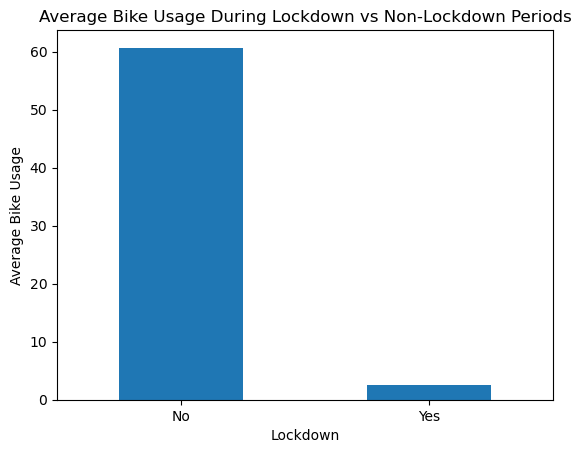

In [10]:
lockdown_dates1 = pd.date_range(start='2020-10-30', end='2020-12-15')
lockdown_dates2 = pd.date_range(start='2021-04-03', end='2021-05-03')
lockdown_dates = lockdown_dates1.union(lockdown_dates2)

data['lockdown'] = data['date'].isin(lockdown_dates).astype(int)

# Calculate average bike usage during lockdown and non-lockdown periods
avg_bike_usage = data.groupby('lockdown')['bike_count'].mean()

# Plot the results
avg_bike_usage.plot(kind='bar', x='lockdown', y='bike_count')
plt.title('Average Bike Usage During Lockdown vs Non-Lockdown Periods')
plt.xlabel('Lockdown')
plt.ylabel('Average Bike Usage')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

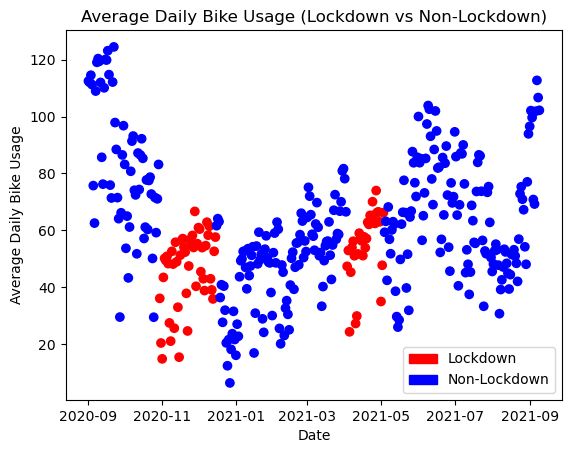

In [11]:
import matplotlib.patches as mpatches

# Calculate average daily bike usage
data['day'] = data['date'].dt.date
avg_daily_usage = data.groupby('day')['bike_count'].mean().reset_index()

# Create a color column based on 'lockdown'
avg_daily_usage['color'] = avg_daily_usage['day'].isin(lockdown_dates.date).map({True: 'red', False: 'blue'})

# Plot the results
plt.scatter(avg_daily_usage['day'], avg_daily_usage['bike_count'], c=avg_daily_usage['color'])

# Create a legend
red_patch = mpatches.Patch(color='red', label='Lockdown')
blue_patch = mpatches.Patch(color='blue', label='Non-Lockdown')
plt.legend(handles=[red_patch, blue_patch])

plt.title('Average Daily Bike Usage (Lockdown vs Non-Lockdown)')
plt.xlabel('Date')
plt.ylabel('Average Daily Bike Usage')
plt.show()

# Check if Curfews made an effect

In [14]:
# source https://www.ouest-france.fr/sante/virus/coronavirus/couvre-feu/fin-du-couvre-feu-dimanche-les-sept-dates-cles-d-une-mesure-phare-de-la-lutte-contre-le-covid-19-7305647
def is_curfew(year, month, day, hour):
    date = pd.Timestamp(year, month, day)
    if date >= pd.Timestamp('2020-10-17') and date < pd.Timestamp('2020-12-15'):
        return 21 <= hour < 6
    elif date >= pd.Timestamp('2020-12-15') and date < pd.Timestamp('2021-01-16'):
        return 20 <= hour < 6
    elif date >= pd.Timestamp('2021-01-16') and date < pd.Timestamp('2021-03-20'):
        return 18 <= hour < 6
    elif date >= pd.Timestamp('2021-03-20') and date < pd.Timestamp('2021-05-19'):
        return 19 <= hour < 6
    elif date >= pd.Timestamp('2021-05-19') and date < pd.Timestamp('2021-06-09'):
        return 21 <= hour < 6
    elif date >= pd.Timestamp('2021-06-09') and date < pd.Timestamp('2021-06-20'):
        return 23 <= hour < 6
    else:
        return False
    
data = _encode_dates(data)

# Apply the function to each row in the DataFrame
data['curfew'] = data.apply(lambda row: is_curfew(row['year'], row['month'], row['day'], row['hour']), axis=1).astype(int)


C:\Users\Gaspard\AppData\Local\Temp\ipykernel_1816\3988649186.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, "day"] = X["date"].dt.day


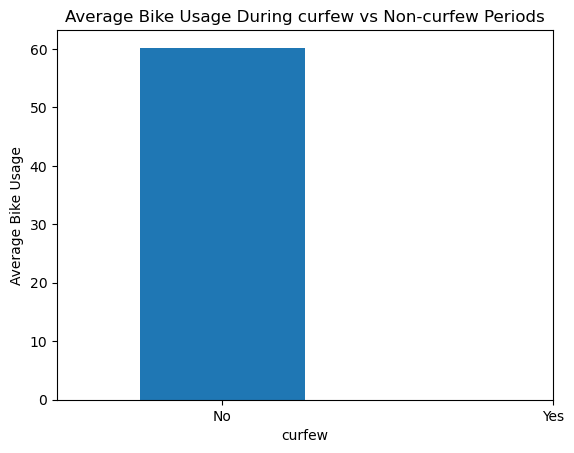

In [15]:
# Calculate average bike usage during lockdown and non-lockdown periods
avg_bike_usage = data.groupby('curfew')['bike_count'].mean()

# Plot the results
avg_bike_usage.plot(kind='bar', x='curfew', y='bike_count')
plt.title('Average Bike Usage During curfew vs Non-curfew Periods')
plt.xlabel('curfew')
plt.ylabel('Average Bike Usage')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)
plt.show()

In [16]:
#check graph manually to see how many times a bike was taken during curfews 
print(data['curfew'].value_counts())

0    496827
Name: curfew, dtype: int64


No one use the Velib during the curfews so no need to make it a feature 

# To keep track of different models used, decided to make a new cell for each different method used 

In [33]:
# Initialize an empty list to store the results
results = []


# With external data and cyclical hour encoding

In [47]:
import numpy as np
import pandas  as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import time



df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")
df_external = pd.read_csv("external_data.csv")


def merge_dataframes(df_train, df_external):
    #rename mulitple columns
    df_external = df_external.rename(columns={
    "ff": "wind_speed",
    "ssfrai": "snowfall",
    "t": "temperature",
    "n": "cloud_coverage",
    "rr1":"rainfall_last_1_hour",
    "rr3":"rainfall_last_3_hour",
    "rr6":"rainfall_last_6_hour",
    "rr12":"rainfall_last_12_hour",
    "rr24":"rainfall_last_24_hour"
    })

    # List of columns to keep
    columns_to_keep = ['date', 'temperature', 'cloud_coverage', 'snowfall', 'wind_speed', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24']

    # Get a list of all columns that are not in columns_to_keep
    columns_to_drop = [col for col in df_external.columns if col not in columns_to_keep]

    # Drop these columns
    df_external = df_external.drop(columns=columns_to_drop)

    # Convert the 'date' column to datetime format
    df_external['date'] = pd.to_datetime(df_external['date'])

    # Group by 'date' and aggregate the other columns
    df_external = df_external.groupby('date').mean()

    # Resample to hourly frequency and interpolate missing values
    df_external = df_external.resample('H').interpolate()

    df_external.reset_index(inplace=True)
    df_external.rename(columns={'index': 'date'}, inplace=True)
    df_merged = pd.merge(df_train, df_external, how='left', on='date')
    return df_merged

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    
    # Encode hours in a cyclical way
    X.loc[:, "hour_sin"] = np.sin(2 * np.pi * X["date"].dt.hour/24)
    X.loc[:, "hour_cos"] = np.cos(2 * np.pi * X["date"].dt.hour/24)
    


    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    
def prepare_data(df):
    # days since istallation feature
    df['days_since_installation'] = (pd.Timestamp.now() - df['counter_installation_date']).dt.days

    # drop unecessary columns 
    columns_to_drop = ["bike_count", "site_name", "counter_name", "latitude", "coordinates",
                       "counter_installation_date", "longitude", "counter_id", 
                       "counter_technical_id"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode dates 
    df = _encode_dates(df)
    
    # Replace NaN values with 0
    df = df.fillna(0)
    
    if('log_bike_count' in df.columns): #when using prepare_data on predict set that doesn't have log_bike_count 
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    else: return df, df


def train_model(X, y, model):
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time


def pipeline(df_train, df_test, df_external, model):
    
    # merge with external data 
    df_train = merge_dataframes(df_train, df_external)
    df_test = merge_dataframes(df_test, df_external)
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train)
    X_test, y_test = prepare_data(df_test)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model, training_time = train_model(X_train_scaled, y_train, model)
    
    # Calculate and print Results
    y_pred = model.predict( X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Training Time: ", training_time)
    
    # Store the RMSE and training time with model name
    results.append({'model': type(model).__name__, 'parameters': model.get_params(), 
                    'rmse': rmse, 'time': training_time,
                    'type': "Cyclical Hour with external Weather"}) # hard code what feature engineering we do 
    
    
    return model, X_test_scaled

model = XGBRegressor()

model, X_test = pipeline(df_train, df_test, df_external, model)

RMSE:  0.5521483639829996
Training Time:  5.35228419303894


# With external data and onehot hour encoding

In [46]:
import numpy as np
import pandas  as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import time

df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")
df_external = pd.read_csv("external_data.csv")


def merge_dataframes(df_train, df_external):
    #rename mulitple columns
    df_external = df_external.rename(columns={
    "ff": "wind_speed",
    "ssfrai": "snowfall",
    "t": "temperature",
    "n": "cloud_coverage",
    "rr1":"rainfall_last_1_hour",
    "rr3":"rainfall_last_3_hour",
    "rr6":"rainfall_last_6_hour",
    "rr12":"rainfall_last_12_hour",
    "rr24":"rainfall_last_24_hour"
    })

    # List of columns to keep
    columns_to_keep = ['date', 'temperature', 'cloud_coverage', 'snowfall', 'wind_speed', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24']

    # Get a list of all columns that are not in columns_to_keep
    columns_to_drop = [col for col in df_external.columns if col not in columns_to_keep]

    # Drop these columns
    df_external = df_external.drop(columns=columns_to_drop)

    # Convert the 'date' column to datetime format
    df_external['date'] = pd.to_datetime(df_external['date'])

    # Group by 'date' and aggregate the other columns
    df_external = df_external.groupby('date').mean()

    # Resample to hourly frequency and interpolate missing values
    df_external = df_external.resample('H').interpolate()

    df_external.reset_index(inplace=True)
    df_external.rename(columns={'index': 'date'}, inplace=True)
    df_merged = pd.merge(df_train, df_external, how='left', on='date')
    return df_merged

def _encode_dates_(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    
    # Extract the hour and one-hot encode it
    X.loc[:, 'hour'] = X['date'].dt.hour
    X = pd.get_dummies(X, columns=['hour'])

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    
def prepare_data(df):
    # days since istallation feature
    df['days_since_installation'] = (pd.Timestamp.now() - df['counter_installation_date']).dt.days
    
    # Replace NaN values with 0
    df = df.fillna(0)
    
    # Add a 'lockdown' feature
    lockdown_dates1 = pd.date_range(start='2020-10-30', end='2020-12-15')
    lockdown_dates2 = pd.date_range(start='2021-04-03', end='2021-05-03')
    lockdown_dates = lockdown_dates1.union(lockdown_dates2)
    df['lockdown'] = df['date'].isin(lockdown_dates).astype(int)

    # drop unecessary columns 
    columns_to_drop = ["bike_count", "site_name", "counter_name", "latitude", "coordinates",
                       "counter_installation_date", "longitude", "counter_id", 
                       "counter_technical_id"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode dates 
    df = _encode_dates(df)
    
    if('log_bike_count' in df.columns): #when using prepare_data on predict set that doesn't have log_bike_count 
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    else: return df, df
    

def train_model(X, y, model):
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time


def pipeline(df_train, df_test, df_external, model):
    
    # merge with external data 
    df_train = merge_dataframes(df_train, df_external)
    df_test = merge_dataframes(df_test, df_external)
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train)
    X_test, y_test = prepare_data(df_test)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model, training_time = train_model(X_train_scaled, y_train, model)
    
    # Calculate and print Results
    y_pred = model.predict( X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Training Time: ", training_time)
    
    # Store the RMSE and training time with model name
    results.append({'model': type(model).__name__, 'parameters': model.get_params(), 
                    'rmse': rmse, 'time': training_time,
                    'type': "One hot Encoding Hour with external Weather and Lockdown Feature"}) # hard code what feature engineering we do 
    
    
    return model, X_test_scaled

model = XGBRegressor()

model, X_test = pipeline(df_train, df_test, df_external, model)

RMSE:  0.5494444014198185
Training Time:  5.2824790477752686


# With Weather data I found 

In [45]:
import numpy as np
import pandas  as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import time

df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")
df_external = pd.read_csv("hourly_weather_data.csv")


def merge_dataframes(df, df_weather):
    df['date'] = pd.to_datetime(df['date'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])
    # Merge the DataFrames
    df_merged = pd.merge(df, df_weather, on='date', how='left')
    
    return df_merged

def _encode_dates_(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    
    # Extract the hour and one-hot encode it
    X.loc[:, 'hour'] = X['date'].dt.hour
    X = pd.get_dummies(X, columns=['hour'])

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    
def prepare_data(df):
    # Add a 'lockdown' feature
    lockdown_dates1 = pd.date_range(start='2020-10-30', end='2020-12-15')
    lockdown_dates2 = pd.date_range(start='2021-04-03', end='2021-05-03')
    lockdown_dates = lockdown_dates1.union(lockdown_dates2)
    df['lockdown'] = df['date'].isin(lockdown_dates).astype(int)

    # drop unecessary columns 
    columns_to_drop = ["bike_count", "site_name", "counter_name", "latitude", "coordinates",
                       "counter_installation_date", "longitude", "counter_id", 
                       "counter_technical_id"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Replace NaN values with 0
    df = df.fillna(0)
    
    # Encode dates 
    df = _encode_dates(df)
    
    if('log_bike_count' in df.columns): #when using prepare_data on predict set that doesn't have log_bike_count 
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    else: return df, df
    

def train_model(X, y, model):
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time


def pipeline(df_train, df_test, df_external, model):
    
    # merge with external data 
    df_train = merge_dataframes(df_train, df_external)
    df_test = merge_dataframes(df_test, df_external)
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train)
    X_test, y_test = prepare_data(df_test)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model, training_time = train_model(X_train_scaled, y_train, model)
    
    # Calculate and print Results
    y_pred = model.predict( X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Training Time: ", training_time)
    
    # Store the RMSE and training time with model name
    results.append({'model': type(model).__name__, 'parameters': model.get_params(), 
                    'rmse': rmse, 'time': training_time,
                    'type': "One hot Encoding Hour, My Weather, Lockdown Feature, Remove Days_Since_Installation"}) # hard code what feature engineering we do 
    
    
    return model, X_test_scaled

model = XGBRegressor()

model, X_test = pipeline(df_train, df_test, df_external, model)

RMSE:  0.5473218069595381
Training Time:  4.728471517562866


# Add Strike feature

In [44]:
import numpy as np
import pandas  as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import time

df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")
df_external = pd.read_csv("hourly_weather_data.csv")
df_strike = pd.read_csv("mouvements-sociaux-depuis-2002.csv", sep=';')


def merge_dataframes(df, df_weather):
    df['date'] = pd.to_datetime(df['date'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])
    # Merge the DataFrames
    df_merged = pd.merge(df, df_weather, on='date', how='left')
    
    return df_merged

def _encode_dates_(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    
    # Extract the hour and one-hot encode it
    X.loc[:, 'hour'] = X['date'].dt.hour
    X = pd.get_dummies(X, columns=['hour'])

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    
def prepare_data(df, df_strike):
    # Add a 'lockdown' feature
    lockdown_dates1 = pd.date_range(start='2020-10-30', end='2020-12-15')
    lockdown_dates2 = pd.date_range(start='2021-04-03', end='2021-05-03')
    lockdown_dates = lockdown_dates1.union(lockdown_dates2)
    df['lockdown'] = df['date'].isin(lockdown_dates).astype(int)
    
    # Replace NaN values with 0
    df = df.fillna(0)
    
    # add a 'strike' feature
    df_strike = df_strike[(df_strike['Date'] > '2020-09-01') & (df_strike['Date'] < '2021-10-19')]
    df['strike'] = df['date'].isin(df_strike['Date']).astype(int)

    # drop unecessary columns 
    columns_to_drop = ["bike_count", "site_name", "counter_name", "latitude", "coordinates",
                       "counter_installation_date", "longitude", "counter_id", 
                       "counter_technical_id"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode dates 
    df = _encode_dates(df)
    
    if('log_bike_count' in df.columns): #when using prepare_data on predict set that doesn't have log_bike_count 
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    else: return df, df
    

def train_model(X, y, model):
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time


def pipeline(df_train, df_test, df_external, df_strike, model):
    
    # merge with external data 
    df_train = merge_dataframes(df_train, df_external)
    df_test = merge_dataframes(df_test, df_external)
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train, df_strike)
    X_test, y_test = prepare_data(df_test, df_strike)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model, training_time = train_model(X_train_scaled, y_train, model)
    
    # Calculate and print Results
    y_pred = model.predict( X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Training Time: ", training_time)
    
    # Store the RMSE and training time with model name
    results.append({'model': type(model).__name__, 'parameters': model.get_params(), 
                    'rmse': rmse, 'time': training_time,
                    'type': "One hot Encoding Hour, My Weather, Lockdown Feature, Remove Days_Since_Installation, Strike feature"}) 
                    # hard code what feature engineering we do 
    
    
    return model, X_test_scaled

model = XGBRegressor()

model, X_test = pipeline(df_train, df_test, df_external, df_strike, model)

RMSE:  0.5473218069595381
Training Time:  4.47359299659729


slightly worse result with strike feature, so will not implement again

# Without external data

In [43]:
import numpy as np
import pandas  as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import time

df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")


def _encode_dates_(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    
    # Extract the hour and one-hot encode it
    X.loc[:, 'hour'] = X['date'].dt.hour
    X = pd.get_dummies(X, columns=['hour'])

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    
def prepare_data(df):
    # Add a 'lockdown' feature
    lockdown_dates1 = pd.date_range(start='2020-10-30', end='2020-12-15')
    lockdown_dates2 = pd.date_range(start='2021-04-03', end='2021-05-03')
    lockdown_dates = lockdown_dates1.union(lockdown_dates2)
    df['lockdown'] = df['date'].isin(lockdown_dates).astype(int)
    
    # Replace NaN values with 0
    df = df.fillna(0)

    # drop unecessary columns 
    columns_to_drop = ["bike_count", "site_name", "counter_name", "latitude", "coordinates",
                       "counter_installation_date", "longitude", "counter_id", 
                       "counter_technical_id"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode dates 
    df = _encode_dates(df)
    
    if('log_bike_count' in df.columns): #when using prepare_data on predict set that doesn't have log_bike_count 
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    else: return df, df
    

def train_model(X, y, model):
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time


def pipeline(df_train, df_test, model):
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train)
    X_test, y_test = prepare_data(df_test)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model, training_time = train_model(X_train_scaled, y_train, model)
    
    # Calculate and print Results
    y_pred = model.predict( X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Training Time: ", training_time)
    
    # Store the RMSE and training time with model name
    results.append({'model': type(model).__name__, 'parameters': model.get_params(), 
                    'rmse': rmse, 'time': training_time,
                    'type': "One hot Encoding Hour, Lockdown Feature, Remove Days_Since_Installation"}) 
                    # hard code what feature engineering we do 
    
    
    return model, X_test_scaled

model = XGBRegressor()

model, X_test = pipeline(df_train, df_test, model)

RMSE:  0.5491439661086466
Training Time:  2.6293225288391113


Slightly worse without external data, but when submitting on kaggle get better result. Need to continue investigating

# perform grid search

In [41]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas  as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import time
from sklearn.model_selection import TimeSeriesSplit


df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")

def train_model_grid_search(X, y, model, param_grid):

    # better than cross validation when dealing with time series
    tscv = TimeSeriesSplit(n_splits=3)
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    
    return best_model, best_params


def pipeline(df_train, df_test, df_external, model, param_grid):
    
    # merge with external data 
    df_train = merge_dataframes(df_train, df_external)
    df_test = merge_dataframes(df_test, df_external)
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train)
    X_test, y_test = prepare_data(df_test)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform grid search
    best_model, best_params = train_model_grid_search(X_train_scaled, y_train, model, param_grid)
    
    # Calculate and print Results
    y_pred = best_model.predict( X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Best Parameters : ", best_params)
    
    
    return model, X_test_scaled

model = XGBRegressor()

param_grid = {
        'n_estimators': [115, 125, 100],
        'max_depth': [6, 5],
        'learning_rate': [0.1],
        'min_child_weight': [3, 5],
        'booster': ['gbtree'],
        'base_score': [0.75, 0.8]
    }

model, X_test = pipeline(df_train, df_test, df_external, model, param_grid)

RMSE:  0.5914002109489148
Best Parameters :  {'base_score': 0.8, 'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 125}


In [42]:
import numpy as np
import pandas  as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import time

df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")
df_external = pd.read_csv("hourly_weather_data.csv")
df_strike = pd.read_csv("mouvements-sociaux-depuis-2002.csv", sep=';')


def merge_dataframes(df, df_weather):
    df['date'] = pd.to_datetime(df['date'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])
    # Merge the DataFrames
    df_merged = pd.merge(df, df_weather, on='date', how='left')
    
    return df_merged

def _encode_dates_(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    
    # Extract the hour and one-hot encode it
    X.loc[:, 'hour'] = X['date'].dt.hour
    X = pd.get_dummies(X, columns=['hour'])

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    
def prepare_data(df, df_strike):
    # Add a 'lockdown' feature
    lockdown_dates1 = pd.date_range(start='2020-10-30', end='2020-12-15')
    lockdown_dates2 = pd.date_range(start='2021-04-03', end='2021-05-03')
    lockdown_dates = lockdown_dates1.union(lockdown_dates2)
    df['lockdown'] = df['date'].isin(lockdown_dates).astype(int)
    
    # Replace NaN values with 0
    df = df.fillna(0)
    
    # add a 'strike' feature
    df_strike = df_strike[(df_strike['Date'] > '2020-09-01') & (df_strike['Date'] < '2021-10-19')]
    df['strike'] = df['date'].isin(df_strike['Date']).astype(int)

    # drop unecessary columns 
    columns_to_drop = ["bike_count", "site_name", "counter_name", "latitude", "coordinates",
                       "counter_installation_date", "longitude", "counter_id", 
                       "counter_technical_id"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode dates 
    df = _encode_dates(df)
    
    if('log_bike_count' in df.columns): #when using prepare_data on predict set that doesn't have log_bike_count 
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    else: return df, df
    

def train_model(X, y, model):
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time


def pipeline(df_train, df_test, df_external, df_strike, model):
    
    # merge with external data 
    df_train = merge_dataframes(df_train, df_external)
    df_test = merge_dataframes(df_test, df_external)
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train, df_strike)
    X_test, y_test = prepare_data(df_test, df_strike)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model, training_time = train_model(X_train_scaled, y_train, model)
    
    # Calculate and print Results
    y_pred = model.predict( X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Training Time: ", training_time)
    
    # Store the RMSE and training time with model name
    results.append({'model': type(model).__name__, 'parameters': model.get_params(), 
                    'rmse': rmse, 'time': training_time,
                    'type': " Updated Best Parameters, One hot Encoding Hour, My Weather, Lockdown Feature, Remove Days_Since_Installation, Strike feature"}) 
                    # hard code what feature engineering we do 
    
    
    return model, X_test_scaled

model = XGBRegressor(
        n_estimators=125,
        max_depth=6,
        learning_rate=0.1,
        min_child_weight=5,
        booster='gbtree',
        base_score=0.8
    )

model, X_test = pipeline(df_train, df_test, df_external, df_strike, model)

RMSE:  0.5914002109489148
Training Time:  4.424667596817017


# Try RandomForestRegressor

In [37]:
import numpy as np
import pandas  as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import time

df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")
df_external = pd.read_csv("hourly_weather_data.csv")


def merge_dataframes(df, df_weather):
    df['date'] = pd.to_datetime(df['date'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])
    # Merge the DataFrames
    df_merged = pd.merge(df, df_weather, on='date', how='left')
    
    return df_merged

def _encode_dates_(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    
    # Extract the hour and one-hot encode it
    X.loc[:, 'hour'] = X['date'].dt.hour
    X = pd.get_dummies(X, columns=['hour'])

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    
def prepare_data(df):
    # Add a 'lockdown' feature
    lockdown_dates1 = pd.date_range(start='2020-10-30', end='2020-12-15')
    lockdown_dates2 = pd.date_range(start='2021-04-03', end='2021-05-03')
    lockdown_dates = lockdown_dates1.union(lockdown_dates2)
    df['lockdown'] = df['date'].isin(lockdown_dates).astype(int)
    
    # Replace NaN values with 0
    df = df.fillna(0)

    # drop unecessary columns 
    columns_to_drop = ["bike_count", "site_name", "counter_name", "latitude", "coordinates",
                       "counter_installation_date", "longitude", "counter_id", 
                       "counter_technical_id"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode dates 
    df = _encode_dates(df)
    
    if('log_bike_count' in df.columns): #when using prepare_data on predict set that doesn't have log_bike_count 
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    else: return df, df
    

def train_model(X, y, model):
    start_time = time.time()
    model.fit(X, y)
    end_time = time.time()
    training_time = end_time - start_time
    return model, training_time


def pipeline(df_train, df_test, df_external, model):
    
    # merge with external data 
    df_train = merge_dataframes(df_train, df_external)
    df_test = merge_dataframes(df_test, df_external)
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train)
    X_test, y_test = prepare_data(df_test)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model, training_time = train_model(X_train_scaled, y_train, model)
    
    # Calculate and print Results
    y_pred = model.predict( X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Training Time: ", training_time)
    
    # Store the RMSE and training time with model name
    results.append({'model': type(model).__name__, 'parameters': model.get_params(), 
                    'rmse': rmse, 'time': training_time,
                    'type': "RandomTree, One hot Encoding Hour, My Weather, Lockdown Feature, Remove Days_Since_Installation"}) # hard code what feature engineering we do 
    
    
    return model, X_test_scaled

model = RandomForestRegressor()

model, X_test = pipeline(df_train, df_test, df_external, model)

RMSE:  0.645761626367935
Training Time:  254.69348859786987


# Using recurent neural network, Short_term memory (LSTM)

In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import time

df_train = pd.read_parquet( "train1.parquet")
df_test = pd.read_parquet("train2.parquet")
df_external = pd.read_csv("hourly_weather_data.csv")


def merge_dataframes(df, df_weather):
    df['date'] = pd.to_datetime(df['date'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])
    # Merge the DataFrames
    df_merged = pd.merge(df, df_weather, on='date', how='left')
    
    return df_merged

def _encode_dates_(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    
    # Extract the hour and one-hot encode it
    X.loc[:, 'hour'] = X['date'].dt.hour
    X = pd.get_dummies(X, columns=['hour'])

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])
    
def prepare_data(df):
    # Add a 'lockdown' feature
    lockdown_dates1 = pd.date_range(start='2020-10-30', end='2020-12-15')
    lockdown_dates2 = pd.date_range(start='2021-04-03', end='2021-05-03')
    lockdown_dates = lockdown_dates1.union(lockdown_dates2)
    df['lockdown'] = df['date'].isin(lockdown_dates).astype(int)
    
    # Replace NaN values with 0
    df = df.fillna(0)

    # drop unecessary columns 
    columns_to_drop = ["bike_count", "site_name", "counter_name", "latitude", "coordinates",
                       "counter_installation_date", "longitude", "counter_id", 
                       "counter_technical_id"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode dates 
    df = _encode_dates(df)
    
    if('log_bike_count' in df.columns): #when using prepare_data on predict set that doesn't have log_bike_count 
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    else: return df, df
        

def train_model(X, y, model):
    # Reshape input to be 3D [samples, timesteps, features]
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # Define the LSTM model
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    start_time = time.time()
    # Fit the model
    model.fit(X, y, epochs=50, batch_size=72, verbose=0)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    return model, training_time

def pipeline(df_train, df_test, df_external, model):
    
    # merge with external data 
    df_train = merge_dataframes(df_train, df_external)
    df_test = merge_dataframes(df_test, df_external)
    
    # split into X and y and prepare data 
    X_train, y_train = prepare_data(df_train)
    X_test, y_test = prepare_data(df_test)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model, training_time = train_model(X_train_scaled, y_train, model)
    
    # Reshape X_test to be 3D [samples, timesteps, features]
    X_test_scaled_3D = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    
    # Calculate and print Results
    y_pred = model.predict( X_test_scaled_3D)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("RMSE: ", rmse)
    print("Training Time: ", training_time)
    
    # Store the RMSE and training time with model name
    results.append({'model': type(model).__name__, 'parameters': model.get_config(), 
                    'rmse': rmse, 'time': training_time,
                    'type': "LSTM, One hot Encoding Hour, My Weather, Lockdown Feature, Remove Days_Since_Installation"}) # hard code what feature engineering we do 
    
    
    return model, X_test_scaled

model = Sequential()

model, X_test = pipeline(df_train, df_test, df_external, model)


15526/15526 [==============================] - 31s 2ms/step
RMSE:  0.9565611015177061
Training Time:  910.2973487377167


In [35]:
results = []

# Plot The results

best parameters =  {'base_score': 0.8, 'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 115}

C:\Users\Gaspard\AppData\Local\Temp\ipykernel_10136\629111182.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


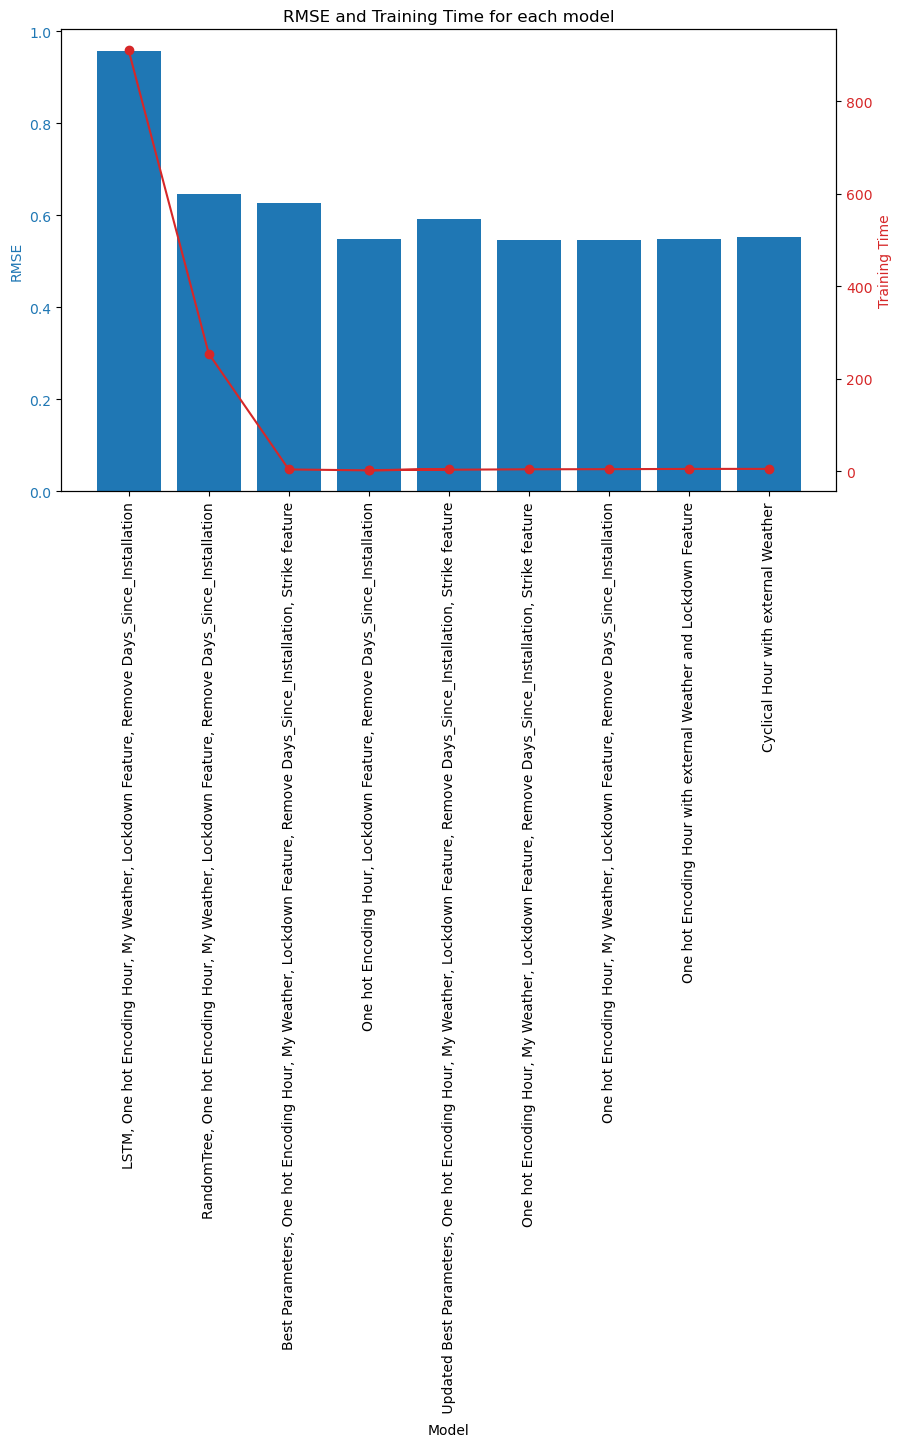

In [48]:
import matplotlib.pyplot as plt


# Extract model names, RMSE values, and training times
models = [result['type'] for result in results]
rmse_values = [result['rmse'] for result in results]
training_times = [result['time'] for result in results]


# Create a bar plot for RMSE
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color=color)
ax1.bar(models, rmse_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Create a second y-axis for training time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time', color=color)
ax2.plot(models, training_times, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('RMSE and Training Time for each model')
plt.show()